In [14]:
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
#from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import r2_score, mean_squared_error
#import AllTogether as t
import seaborn as sns
#%matplotlib inline

<h3> Loading and exploring the Seattle Airbnb Data </h3>

In this first section, we are going to load and explore the Seattle Airbnb Data set. The aim is to identify the most important features which we can use to answer the business questions given above.

In [84]:
df_seattle_calendar = pd.read_csv('./seattle_airbnb_data/calendar.csv')
df_seattle_listings = pd.read_csv('./seattle_airbnb_data/listings.csv')
df_seattle_reviews = pd.read_csv('./seattle_airbnb_data/reviews.csv')

In [85]:
df_seattle_calendar = df_seattle_calendar.dropna()

In [86]:
df_seattle_calendar['date'] = pd.to_datetime(df_seattle_calendar['date'])
df_seattle_calendar['available'] = df_seattle_calendar['available'].map({'t': 1, 'f': 0})
df_seattle_calendar['price'] = df_seattle_calendar['price'].str.replace('[\$,]', '', regex=True).astype(float)

#plt.matshow(df_seattle_calendar.corr(method='spearman'))
#plt.show()

In [88]:
df_seattle_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,1,85.0
1,241032,2016-01-05,1,85.0
9,241032,2016-01-13,1,85.0
10,241032,2016-01-14,1,85.0
14,241032,2016-01-18,1,85.0


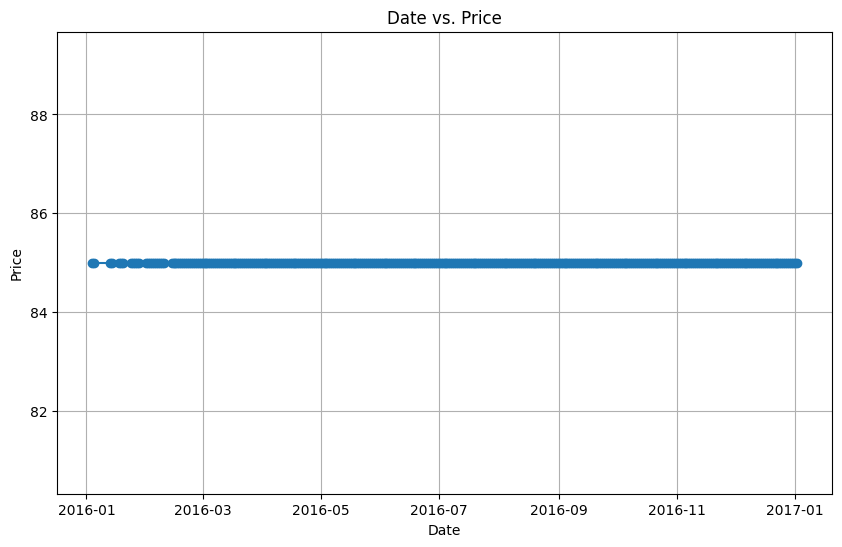

In [89]:
df_seattle_calendar = df_seattle_calendar[df_seattle_calendar['listing_id'] == 241032]

plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(df_seattle_calendar['date'], df_seattle_calendar['price'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Date vs. Price')
plt.grid(True)  # Add grid for better readability
plt.show()

In [56]:
df_seattle_listings.isna().sum().sort_values(ascending=False).head(30)

license                        3818
square_feet                    3721
monthly_price                  2301
security_deposit               1952
weekly_price                   1809
notes                          1606
neighborhood_overview          1032
cleaning_fee                   1030
transit                         934
host_about                      859
host_acceptance_rate            773
review_scores_checkin           658
review_scores_accuracy          658
review_scores_value             656
review_scores_location          655
review_scores_cleanliness       653
review_scores_communication     651
review_scores_rating            647
last_review                     627
reviews_per_month               627
first_review                    627
space                           569
host_response_time              523
host_response_rate              523
neighbourhood                   416
xl_picture_url                  320
medium_url                      320
thumbnail_url               

In [39]:
id_value = 241032
 
result = df_seattle_calendar[df_seattle_calendar['listing_id'] == id_value]
 
print(result)

     listing_id        date available   price
0        241032  2016-01-04         t  $85.00
1        241032  2016-01-05         t  $85.00
2        241032  2016-01-06         f     NaN
3        241032  2016-01-07         f     NaN
4        241032  2016-01-08         f     NaN
..          ...         ...       ...     ...
360      241032  2016-12-29         t  $85.00
361      241032  2016-12-30         t  $85.00
362      241032  2016-12-31         t  $85.00
363      241032  2017-01-01         t  $85.00
364      241032  2017-01-02         t  $85.00

[365 rows x 4 columns]


In [42]:
id_value = 241032
 
result = df_seattle_listings[df_seattle_listings['id'] == id_value]
 
result

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07


In [44]:
id_value = 241032
 
result = df_seattle_reviews[df_seattle_reviews['listing_id'] == id_value]
 
result

,listing_id,id,date,reviewer_id,reviewer_name,comments
46381,241032,682061,2011-11-01,479824,Bro,Excellent all the way around. \r\n\r\nMaija wa...
46382,241032,691712,2011-11-04,357699,Megan,Maija's apartment was a wonderful place to sta...
46383,241032,702999,2011-11-08,1285567,Marylee,one of the most pleasant stays i've had in my ...
46384,241032,717262,2011-11-14,647857,Graham,"Maija's suite is beautiful, cozy and convenien..."
46385,241032,730226,2011-11-19,1389821,Franka,Our stay was short and pleasant. With its own ...
...,...,...,...,...,...,...
46583,241032,55971781,2015-12-07,16860585,Alexis,"It was a wonderful stay! Beautiful, clean apar..."
46584,241032,56765240,2015-12-17,2772019,Matt,Maija's place is wonderful and exactly as desc...
46585,241032,57116731,2015-12-22,33390495,Wendy,The apartment was perfect for our stay! It wa...
46586,241032,57357433,2015-12-24,9664864,Vas,The home is a little tricky to find because of...
